In [101]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures

# JUST_ABOVE_ONE = 1.00000001 # np.random high arg is exclusive
JUST_ABOVE_ONE = np.nextafter(1.0, np.inf) # np.random high arg is exclusive
JUST_BELOW_ZERO = np.nextafter(0.0, -np.inf) # np.random low arg is inclusive

In [107]:
def isotropic_direction_distribution(number_of_particles=1):
    distribution = np.cos(np.pi * np.random.uniform(low=0, high=JUST_ABOVE_ONE, size=number_of_particles))
    if number_of_particles == 1:
        return distribution[0]
    return distribution

class Surface:
    def __init__(self, id, location):
        self.id = id
        self.location = location
        
        self.number_of_particles_passing_pos = 0
        self.number_of_particles_passing_neg = 0
        
    def pos_particle_pass(self):
        self.number_of_particles_passing_pos += 1
        
    def neg_particle_pass(self):
        self.number_of_particles_passing_neg += 1

class Material:
    def __init__(self, volumetric_source=0, sigma_total=1, sigma_scatter=0):
        self.volumetric_source = volumetric_source
        self.sigma_total = sigma_total
        self.sigma_scatter = sigma_scatter
        self.sigma_absorb = sigma_total - sigma_scatter
        
    def interaction_type(self):
        return np.random.choice(
            ["scatter", "absorb"],
            p=[self.sigma_scatter, self.sigma_absorb]
        )


class Cell:
    def __init__(self, id, width, material: Material, left_surface : Surface, right_surface : Surface):
        self.id = id
        self.width = width
        self.material = material
        self.left_surface = left_surface
        self.right_surface = right_surface
        
        self.neutron_histories = 0
        self.interaction_tally = 0
        self.absorption_tally = 0
        self.scattering_tally = 0
        self.track_length_tally = 0   
        
    def add_neutron_history(self):
        self.neutron_histories += 1
        
    def scatter(self):
        self.scattering_tally += 1
        self.interaction_tally += 1
        
    def absorb(self):
        self.absorption_tally += 1
        self.interaction_tally += 1
        
    def add_track_length(self, track_length):
        self.add_neutron_history()
        self.track_length_tally += abs(track_length)


class Mesh:
    def __init__(self, problem_width, num_cells, material : Material):
        """Assuming uniform material and uniform cell spacing"""
        self.problem_width = problem_width
        self.num_cells = num_cells
        self.num_surfaces = num_cells + 1
        self.cell_width = problem_width / num_cells
        self.material = material

        self.surfaces = [Surface(i, i * self.cell_width) for i in range(self.num_surfaces)]        
        self.cells = [Cell(i, self.cell_width, material, self.surfaces[i], self.surfaces[i+1]) for i in range(self.num_cells)]
        
    def get_cell(self, position):
        cell_id = int(position / self.cell_width) # floor
        if cell_id == self.num_cells:
            return self.cells[-1]
        return self.cells[cell_id]
    
    def get_surface_x_positions(self):
        return np.array([surface.location for surface in self.surfaces])
    
    def get_cell_x_positions(self):
        half_width = self.cell_width / 2
        return np.array([cell.left_surface.location + half_width for cell in self.cells])
    
    def get_absorption_tally(self):
        return np.array([cell.absorption_tally for cell in self.cells])
    
    def get_total_collision_tally(self):
        return np.array([cell.interaction_tally for cell in self.cells])
    
    def get_scalar_flux_collision_tally(self, number_of_particles):
        return np.array([cell.interaction_tally / cell.material.sigma_total / cell.width for cell in self.cells]) / number_of_particles
        # return np.array([cell.interaction_tally for cell in self.cells]) / number_of_particles
    
    def get_scalar_flux_track_length_tally(self, number_of_particles):
        return np.array([cell.track_length_tally / cell.width for cell in self.cells]) / number_of_particles
    
    def get_current_tally(self, number_of_particles):
        return np.array([surface.number_of_particles_passing_pos - surface.number_of_particles_passing_neg for surface in self.surfaces]) / number_of_particles
    

class Source:
    def __init__(self, number_of_particles):
        self.number_of_particles = number_of_particles
        
    def direction_distribution(self):
        raise NotImplementedError
    
    def location_distribution(self):
        raise NotImplementedError

class UniformSurfaceSource(Source):
    def __init__(self, number_of_particles, location=0, direction=1):
        super().__init__(number_of_particles)
        self.location = location
        self.direction = direction
        
    def direction_distribution(self):
        return np.full(self.number_of_particles, self.direction)
    
    def location_distribution(self):
        return np.full(self.number_of_particles, self.location)

class IsotropicVolumetricSource(Source):
    def __init__(self, number_of_particles, location_min=0, location_max=1):
        super().__init__(number_of_particles)
        self.location_min = location_min
        self.location_max = location_max

    def direction_distribution(self):
        return isotropic_direction_distribution(self.number_of_particles)

    def location_distribution(self):
        return np.random.uniform(low=self.location_min, high=self.location_max, size=self.number_of_particles)


class MonteCarlo():
    def __init__(self, sources: list[Source], mesh : Mesh, left_boundary=None, right_boundary=None):
        """
        • A mesh to compute the spatial distribution of the scalar flux and
        reaction rates
        • A collision to compute the reaction rates then derive the scalar
        flux from it.
        • A surface tally to compute the current at the right and left sur-
        faces of the problem
        • A track-length tally to compute the scalar flux in every mesh
        cell.
        """
        self.sources : list[Source] = sources
        self.mesh : Mesh = mesh

        assert (
            left_boundary is None or left_boundary == "reflecting"
        ), "left_boundary must be none or 'reflecting'"
        self.left_boundary = left_boundary
        assert (
            right_boundary is None or right_boundary == "reflecting"
        ), "right_boundary must be none or 'reflecting'"
        self.right_boundary = right_boundary

        self.max_cell_transfers = 1000_000
        self.max_interactions = 1000_000

        self.particle_exits_left = 0
        self.particle_exits_right = 0

    def simulate_particle_to_interaction(self, position, direction):
        """Simulate a particle until it reaches an interaction or leaves the system

        Args:
            position (_type_): x location of the particle
            direction (_type_): cosine of the angle of the particle (positive is right, negative is left)
        """

        number_of_mean_free_paths_remaining = -np.log(np.random.uniform(low=0, high=JUST_ABOVE_ONE))        
        current_x_position = position
        current_cell = self.mesh.get_cell(current_x_position)
        
        for i in range(self.max_cell_transfers):
            if i == self.max_cell_transfers-1:
                raise Exception("Max cell transfers reached")

            distance_traveled_in_infinite_material = number_of_mean_free_paths_remaining / current_cell.material.sigma_total
            x_distance_traveled_in_infinite_material = distance_traveled_in_infinite_material * direction

            if direction >= 0:
                # greater than or equal since if it is zero its just not going to reach anyways
                next_surface = current_cell.right_surface
            elif direction < 0:
                next_surface = current_cell.left_surface

            x_distance_to_next_surface = next_surface.location - current_x_position

            if abs(x_distance_to_next_surface) < abs(x_distance_traveled_in_infinite_material):
                # Particle reaches the next surface before interacting with the material
                distanced_traveled_to_next_surface = x_distance_to_next_surface / direction
                # current_cell.add_track_length(distanced_traveled_to_next_surface)
                current_cell.add_track_length(abs(distanced_traveled_to_next_surface))

                number_of_mean_free_paths_remaining -= abs(distanced_traveled_to_next_surface) * current_cell.material.sigma_total
                assert number_of_mean_free_paths_remaining >= 0, "Number of mean free paths remaining cannot be negative"
                # current_x_position += x_distance_to_next_surface
                current_x_position = next_surface.location
                # particle has not had an interaction, so don't update angle

                if current_x_position <= 0:
                    # Particle leaves the system 
                    next_surface.neg_particle_pass()
                    if self.left_boundary == "reflecting":
                        direction = -direction
                        # current_x_position *= -1
                        continue
                    else:
                        break
                elif current_x_position >= self.mesh.problem_width:
                    # Particle leaves the system
                    next_surface.pos_particle_pass()
                    if self.right_boundary == "reflecting":
                        direction = -direction
                        # current_x_position = 2 * self.mesh.problem_width - current_x_position
                        continue
                    else:
                        break

                if direction > 0:
                    next_surface.pos_particle_pass()
                    current_cell = self.mesh.cells[next_surface.id]
                elif direction < 0:
                    next_surface.neg_particle_pass()
                    current_cell = self.mesh.cells[next_surface.id - 1]
                else:
                    raise Exception("Direction cannot be zero with a particle reaching the next surface")
            else:
                # particle has an interaction in current cell
                current_cell.add_track_length(distance_traveled_in_infinite_material)
                current_x_position += x_distance_traveled_in_infinite_material
                break

        return current_x_position, current_cell

    def simulate_particle(self, initial_position, initial_direction):
        """Simulate a particle until it leaves the system or is absorbed"""    
        position = initial_position
        direction = initial_direction

        for i in range(self.max_interactions):
            if i == self.max_interactions-1:
                raise Exception("Max interactions reached")

            position, cell = self.simulate_particle_to_interaction(position, direction)

            if position <= 0:
                self.particle_exits_left += 1
                break
            elif position >= self.mesh.problem_width:
                self.particle_exits_right += 1
                break

            next_interaction = cell.material.interaction_type()
            if next_interaction == "scatter":
                # assuming isotropic scattering
                cell.scatter()
                direction = isotropic_direction_distribution()
                continue
            elif next_interaction == "absorb":
                cell.absorb()
                break
            else:
                raise Exception("Invalid interaction type")
            
            

    def simulate(self):
        """Simulate the transport of particles through the mesh and tally the results"""

        for source in self.sources:
            particle_locations = source.location_distribution()
            particle_directions = source.direction_distribution()

            # [self.simulate_particle(location, direction) for location, direction in zip(particle_locations, particle_directions)]
            for location, direction in zip(particle_locations, particle_directions):
                self.simulate_particle(location, direction)

            # with concurrent.futures.ThreadPoolExecutor() as executor:
            #     executor.map(self.simulate_particle, particle_locations, particle_directions)
            
                
    def plot_tallies(self):
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        x_positions = self.mesh.get_cell_x_positions()
        
        number_of_particles = sum([source.number_of_particles for source in self.sources])
        scalar_flux_collision_tally = self.mesh.get_scalar_flux_collision_tally(number_of_particles)
        scalar_flux_track_length_tally = self.mesh.get_scalar_flux_track_length_tally(number_of_particles)
        
        names = ["Collision", "Track Length"]
        for tally, name,ax, in zip([scalar_flux_collision_tally, scalar_flux_track_length_tally], names, axes):
            ax.plot(x_positions, tally, label=name)

            mean = np.mean(tally)
            std = np.std(tally)
            delta = 2 * std
            ax.fill_between(x_positions, tally - delta, tally + delta, alpha=0.2)

            ax.set_xlabel("Position (cm)")
            ax.set_title(f"{name} Tally")
            
        axes[0].set_ylabel("Scalar Flux Per CSA")
    
        return fig, ax

In [133]:
mu = 1 / np.sqrt(3)
# mu = 0.5
mu = 1
location = 0
problem_width=1
number_of_cells=10
sigma_t = 1

def problem1a_i(
    number_of_particles=10000,
):
    material = Material(sigma_total=1, sigma_scatter=0)
    mesh = Mesh(problem_width, number_of_cells, material)
    left_isotropic_source = UniformSurfaceSource(number_of_particles, location=location ,direction=mu)
    sim = MonteCarlo([left_isotropic_source], mesh)
    sim.simulate()

    collision_tally = sim.mesh.get_scalar_flux_collision_tally(number_of_particles)
    track_length_tally = sim.mesh.get_scalar_flux_track_length_tally(number_of_particles)
    current_tally = sim.mesh.get_current_tally(number_of_particles)
    
    return {
        "Collision": collision_tally * mu,
        "Track Length": track_length_tally * mu,
        "Current" : current_tally * mu
    }

particle_histories = [1000, 10000, 100000, 1000000]
solutions = {
    particle_history : problem1a_i(number_of_particles=particle_history) for particle_history in particle_histories
}


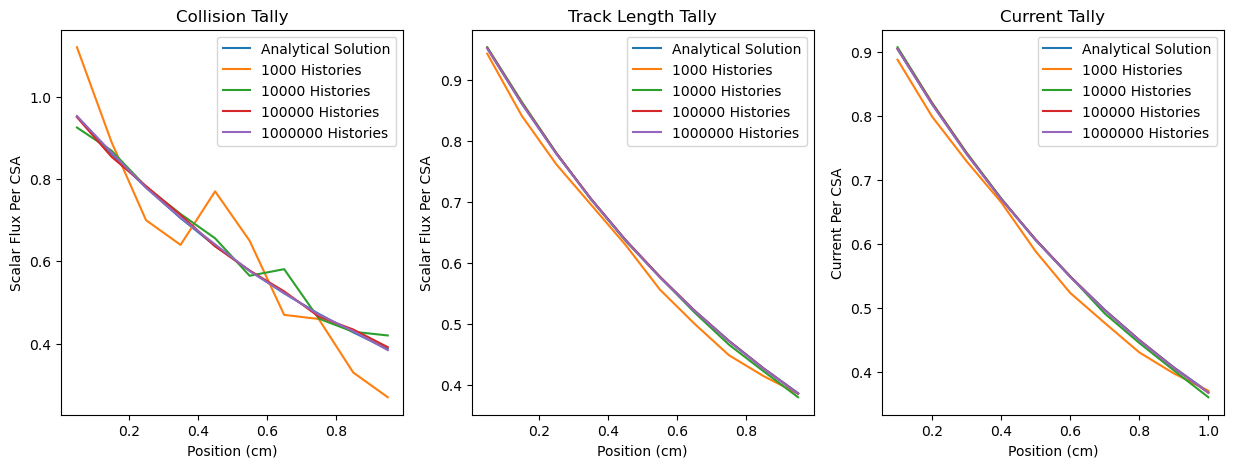

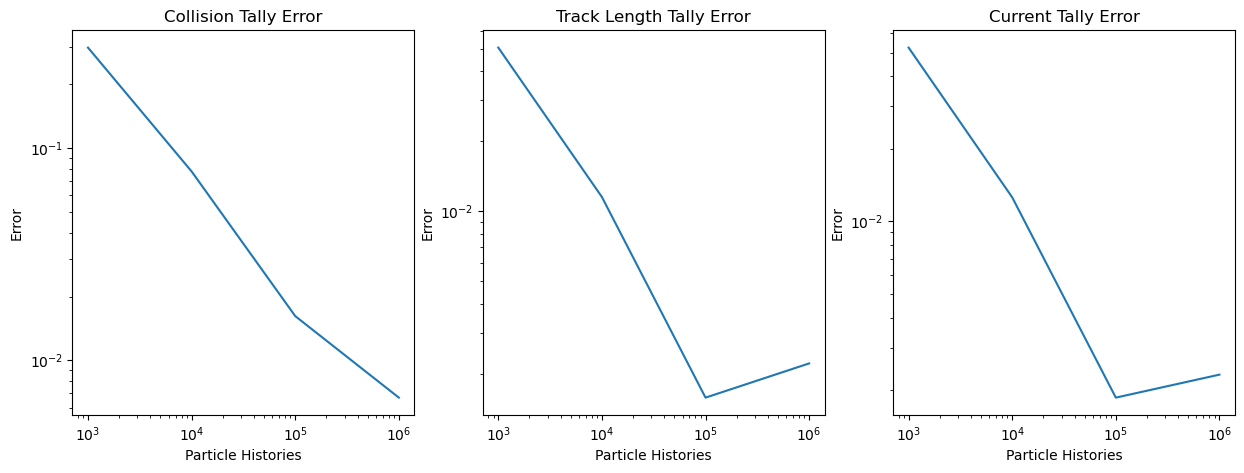

In [134]:
dx = problem_width / number_of_cells
x_avg_positions = [i*dx + - mu*np.log((1-np.exp(-dx/mu))*mu/dx) for i in range(number_of_cells)]
x_surface_positions = [i*dx for i in range(1,number_of_cells+1)]

analytical_solution = lambda x : np.exp(-sigma_t * x / mu)
analytical_solution_values = [analytical_solution(x) for x in x_avg_positions]

analytical_solution_current = lambda x : analytical_solution(x)
analytical_solution_current_values = [mu * analytical_solution_current(x) for x in x_surface_positions]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig_error, axes_error = plt.subplots(1, 3, figsize=(15, 5))

for ax_n, ax_name in enumerate(["Collision", "Track Length"]):
    ax = axes[ax_n]
    ax_error = axes_error[ax_n]
    ax.plot(x_avg_positions, analytical_solution_values, label="Analytical Solution")
    
    error_values = []
    for particle_history, result in solutions.items():
        result_values = result[ax_name]
        ax.plot(x_avg_positions, result_values, label=f"{particle_history} Histories")
        
        error = np.linalg.norm(result_values - analytical_solution_values)
        error_values.append(error)
        
    ax.set_xlabel("Position (cm)")
    ax.set_title(f"{ax_name} Tally")
    ax.set_ylabel("Scalar Flux Per CSA")
    ax.legend()
    # ax.set_xscale("log")
    
    ax_error.plot(particle_histories, error_values)
    ax_error.set_xlabel("Particle Histories")
    ax_error.set_title(f"{ax_name} Tally Error")
    ax_error.set_ylabel("Error")
    ax_error.set_xscale("log")
    ax_error.set_yscale("log")

ax = axes[-1]
ax.plot(x_surface_positions, analytical_solution_current_values, label="Analytical Solution")

error_values = []
for particle_history, result in solutions.items():
    result_values = result["Current"][1:]
    ax.plot(x_surface_positions, result_values, label=f"{particle_history} Histories")
    
    error = np.linalg.norm(result_values - analytical_solution_current_values)
    error_values.append(error)
    
ax.set_xlabel("Position (cm)")
ax.set_title("Current Tally")
ax.set_ylabel("Current Per CSA")
ax.legend()
# ax.set_xscale("log")

ax_error = axes_error[-1]
ax_error.plot(particle_histories, error_values)
ax_error.set_xlabel("Particle Histories")
ax_error.set_title("Current Tally Error")
ax_error.set_ylabel("Error")
ax_error.set_xscale("log")
ax_error.set_yscale("log")

In [130]:
mu = -1
mu = -1 / np.sqrt(3)
location = 1
problem_width = 1
number_of_cells = 10
sigma_t = 1


def problem1a_i_neg(
    number_of_particles=10000,
):
    material = Material(sigma_total=1, sigma_scatter=0)
    mesh = Mesh(problem_width, number_of_cells, material)
    left_isotropic_source = UniformSurfaceSource(
        number_of_particles, location=location, direction=mu
    )
    sim = MonteCarlo([left_isotropic_source], mesh)
    sim.simulate()

    collision_tally = sim.mesh.get_scalar_flux_collision_tally(number_of_particles)
    track_length_tally = sim.mesh.get_scalar_flux_track_length_tally(
        number_of_particles
    )
    current_tally = sim.mesh.get_current_tally(number_of_particles)

    return {
        "Collision": collision_tally * abs(mu),
        "Track Length": track_length_tally * abs(mu),
        "Current": current_tally,
    }


particle_histories = [10000, 50000, 100000, 500000]
solutions = {
    particle_history: problem1a_i_neg(number_of_particles=particle_history)
    for particle_history in particle_histories
}

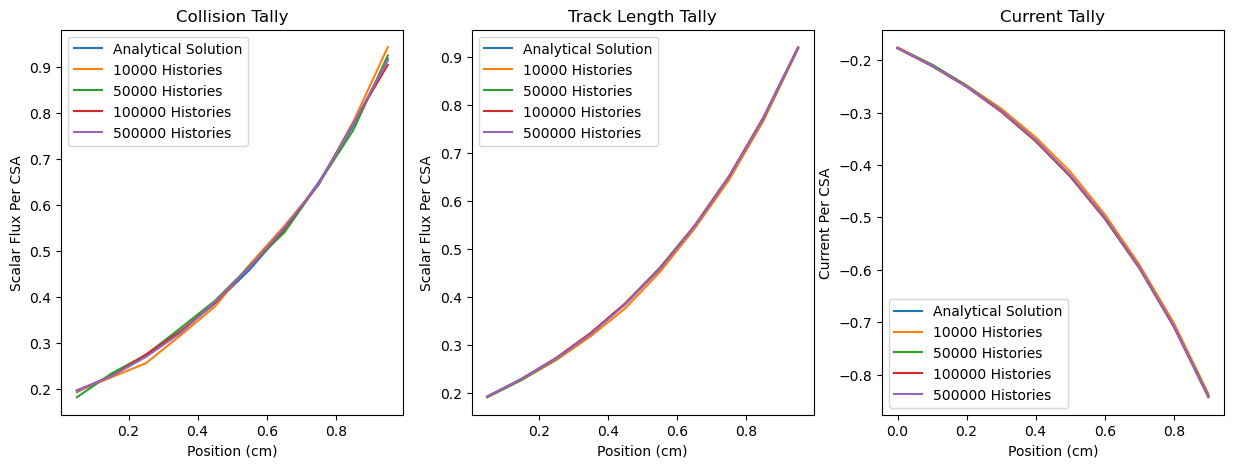

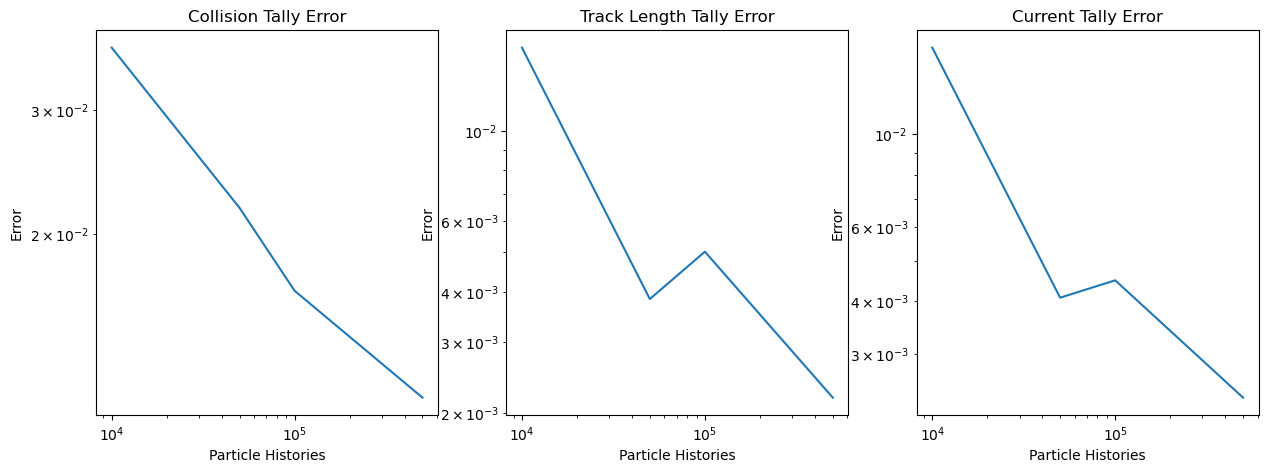

In [132]:
dx = problem_width / number_of_cells
x_avg_positions = [
    (i+1) * dx - -np.log((1 - np.exp(-dx)) / dx) for i in range(number_of_cells)
]
x_surface_positions = [i * dx for i in range(number_of_cells)]

analytical_solution = lambda x:np.exp(sigma_t * (problem_width-x) / mu)
analytical_solution_values = [analytical_solution(x) for x in x_avg_positions]

analytical_solution_current = lambda x: analytical_solution(x) 
analytical_solution_current_values = [
    -analytical_solution_current(x) for x in x_surface_positions
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig_error, axes_error = plt.subplots(1, 3, figsize=(15, 5))

for ax_n, ax_name in enumerate(["Collision", "Track Length"]):
    ax = axes[ax_n]
    ax_error = axes_error[ax_n]
    ax.plot(x_avg_positions, analytical_solution_values, label="Analytical Solution")

    error_values = []
    for particle_history, result in solutions.items():
        result_values = result[ax_name]
        ax.plot(x_avg_positions, result_values, label=f"{particle_history} Histories")

        error = np.linalg.norm(result_values - analytical_solution_values)
        error_values.append(error)

    ax.set_xlabel("Position (cm)")
    ax.set_title(f"{ax_name} Tally")
    ax.set_ylabel("Scalar Flux Per CSA")
    ax.legend()
    # ax.set_xscale("log")

    ax_error.plot(particle_histories, error_values)
    ax_error.set_xlabel("Particle Histories")
    ax_error.set_title(f"{ax_name} Tally Error")
    ax_error.set_ylabel("Error")
    ax_error.set_xscale("log")
    ax_error.set_yscale("log")

ax = axes[-1]
ax.plot(
    x_surface_positions, analytical_solution_current_values, label="Analytical Solution"
)

error_values = []
for particle_history, result in solutions.items():
    result_values = result["Current"][:-1]
    ax.plot(x_surface_positions, result_values, label=f"{particle_history} Histories")

    error = np.linalg.norm(result_values - analytical_solution_current_values)
    error_values.append(error)

ax.set_xlabel("Position (cm)")
ax.set_title("Current Tally")
ax.set_ylabel("Current Per CSA")
ax.legend()

ax_error = axes_error[-1]
ax_error.plot(particle_histories, error_values)
ax_error.set_xlabel("Particle Histories")
ax_error.set_title("Current Tally Error")
ax_error.set_ylabel("Error")
ax_error.set_xscale("log")
ax_error.set_yscale("log")